In [2]:
import gymnasium as gym

from stable_baselines3 import SAC, DDPG, PPO


from environment import *
from env_wrappers import *
from matplotlib import pyplot as plt
from general_utils import *
from delay_model import *
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import torch
from wc_sac import *
from stable_baselines3.common.logger import Logger, configure
import datetime
import copy
from test_utils import *
from train_utils import *
from orchestrator import *
from safe_sac import SafeSAC

%load_ext autoreload
%autoreload 2

plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Comparison between augmentation and model-based prediction

## Augmentation

In [4]:
auglinmodel, lincore_env = train_default_augmented_sac(env_type = 'linear', 
                                                        agent_type = 'augsac', 
                                                        desired_state  = 0.8, 
                                                        n_episodes = 150, 
                                                        random_delay  = False,
                                                        seed  = 42, 
                                                        

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Logging to logs/train/LinearVelocity/0508/Desired0.8/augsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -327     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 25       |
|    time_elapsed    | 18       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 6.14     |
|    critic_loss     | 0.00888  |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -331     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 25       |
|    time_elapsed    | 37       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 11.3     |
|    critic_loss     |

In [5]:
import pandas as pd

nondelayeddf = pd.read_csv('logs\\train\\LinearVelocity\\0506\\Desired0.8\\sac\\progress.csv')
augdf = pd.read_csv('logs\\train\\LinearVelocity\\0508\\Desired0.8\\augsac\\progress.csv')

In [8]:
augdf

,time/total_timesteps,train/n_updates,train/ent_coef,time/time_elapsed,time/fps,time/episodes,train/learning_rate,train/critic_loss,rollout/ep_rew_mean,rollout/ep_len_mean,train/actor_loss
0,480,379,0.5,18,25,4,0.0003,0.008876,-327.463936,120.0,6.140213
1,960,859,0.5,37,25,8,0.0003,0.007381,-331.026594,120.0,11.338899
2,1440,1339,0.5,53,26,12,0.0003,0.010121,-297.003298,120.0,14.633275
3,1920,1819,0.5,70,27,16,0.0003,0.016290,-276.014431,120.0,17.302040
4,2400,2299,0.5,86,27,20,0.0003,0.017213,-251.526163,120.0,21.104172
5,2880,2779,0.5,103,27,24,0.0003,0.023119,-241.450552,120.0,23.382160
6,3360,3259,0.5,127,26,28,0.0003,0.032344,-215.451640,120.0,21.287569
7,3840,3739,0.5,148,25,32,0.0003,0.030991,-200.153793,120.0,23.805233
8,4320,4219,0.5,172,25,36,0.0003,0.028659,-180.661221,120.0,20.264822
9,4800,4699,0.5,189,25,40,0.0003,0.031501,-165.961707,120.0,21.489443


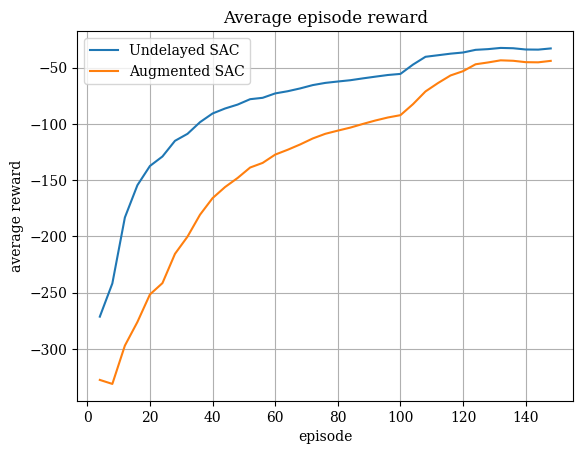

In [11]:
plt.plot(nondelayeddf['time/episodes'], nondelayeddf['rollout/ep_rew_mean'])
plt.plot(nondelayeddf['time/episodes'], augdf['rollout/ep_rew_mean'])
plt.title('Average episode reward')
plt.grid()
plt.xlabel('episode')
plt.ylabel('average reward')
plt.legend(['Undelayed SAC', 'Augmented SAC'])

### Nonlinear velocity

In [12]:
augnlnmodel, nlncore_env = train_default_augmented_sac(env_type = 'nonlinear', 
                                                        agent_type = 'augsac', 
                                                        desired_state  = 1.2, 
                                                        n_episodes = 150, 
                                                        random_delay  = False,
                                                        init_delay = 5,
                                                        seed  = 42)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/NonLinearVelocity/0508/Desired1.2/augsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -171     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 17       |
|    time_elapsed    | 27       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 2.11     |
|    critic_loss     | 0.0255   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -175     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 17       |
|    time_elapsed    | 56       |
|    total_timesteps | 960 

In [13]:
import pandas as pd

nlnondelayeddf = pd.read_csv('logs\\train\\NonLinearVelocity\\0507\\Desired1.2\\sac\\progress.csv')
nlaugdf = pd.read_csv('logs\\train\\NonLinearVelocity\\0508\\Desired1.2\\augsac\\progress.csv')

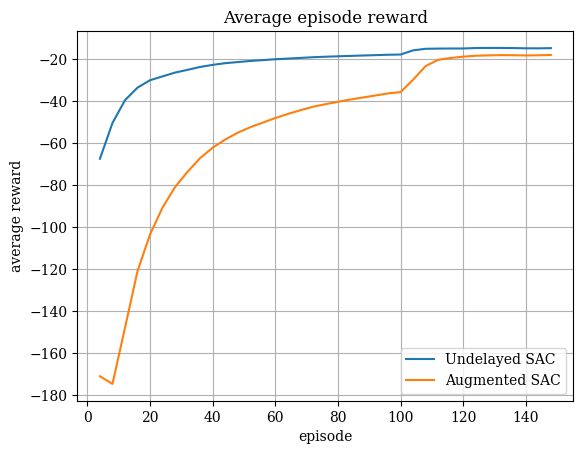

In [14]:
plt.plot(nlnondelayeddf['time/episodes'], nlnondelayeddf['rollout/ep_rew_mean'])
plt.plot(nlaugdf['time/episodes'], nlaugdf['rollout/ep_rew_mean'])
plt.title('Average episode reward')
plt.grid()
plt.xlabel('episode')
plt.ylabel('average reward')
plt.legend(['Undelayed SAC', 'Augmented SAC'])

## Delayed SAC

In [72]:
delayed_model, core_env = train_default_delayed_sac(env_type = 'nonlinear', agent_type='delayedsac', delay = 5, desired_state=1.2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/NonLinearVelocity/0509/Desired1.2/delayedsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -41.3    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 31       |
|    time_elapsed    | 15       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | -0.337   |
|    critic_loss     | 0.0145   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -29.9    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 29       |
|    time_elapsed    | 32       |
|    total_timesteps | 

Delayed model delay : 5
Predicted state [3.87263788] from [3.85333265] and queue [array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
Predicted state [3.78409116] from [3.85718598] and queue [array([0.]), array([0.]), array([0.]), array([0.]), array([-0.92419362])]
Predicted state [3.69554274] from [3.86104316] and queue [array([0.]), array([0.]), array([0.]), array([-0.92419362]), array([-0.92332506])]
Predicted state [3.60699659] from [3.86490421] and queue [array([0.]), array([0.]), array([-0.92419362]), array([-0.92332506]), array([-0.92241699])]
Predicted state [3.5185477] from [3.86876911] and queue [array([0.]), array([-0.92419362]), array([-0.92332506]), array([-0.92241699]), array([-0.92055887])]
Predicted state [3.43020067] from [3.87263788] and queue [array([-0.92419362]), array([-0.92332506]), array([-0.92241699]), array([-0.92055887]), array([-0.91865569])]
Predicted state [3.34195975] from [3.78409116] and queue [array([-0.92332506]), array([-0.92241699]), ar

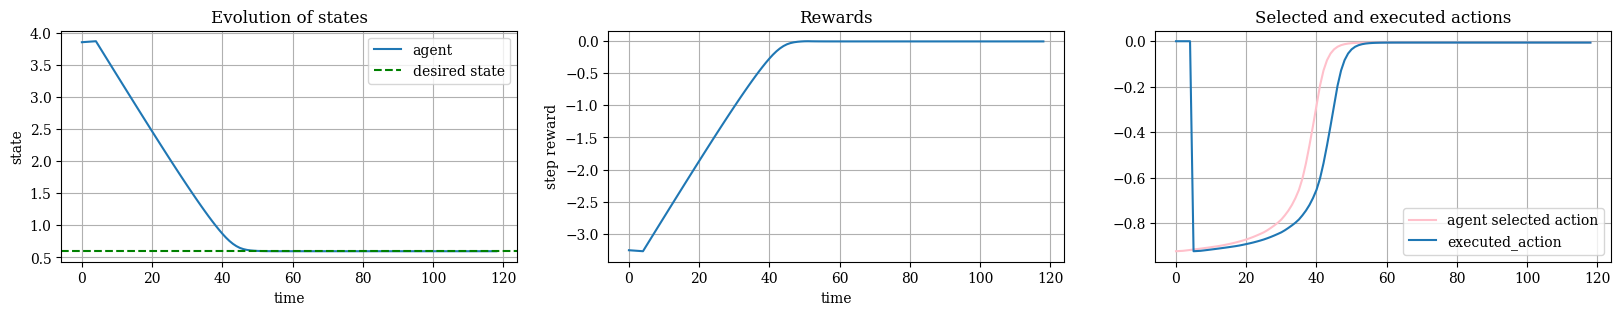

In [66]:
env = DelayAction(RescaleAction(core_env), delay = 5)
print(f"Delayed model delay : {delayed_model.delay}")
delayed_model.original_env = env
states, actions, rewards, avg_rewards, executed_actions = test_augmented_agent(delayed_model, env, deterministic=True)
plot_test(env, states, rewards,actions, executed_actions)

In [ ]:
import pandas as pd

nlnondelayeddf = pd.read_csv('logs\\train\\NonLinearVelocity\\0507\\Desired1.2\\sac\\progress.csv')
nlaugdf = pd.read_csv('logs\\train\\NonLinearVelocity\\0508\\Desired1.2\\augsac\\progress.csv')

plt.plot(nlnondelayeddf['time/episodes'], nlnondelayeddf['rollout/ep_rew_mean'])
plt.plot(nlaugdf['time/episodes'], nlaugdf['rollout/ep_rew_mean'])
plt.title('Average episode reward')
plt.grid()
plt.xlabel('episode')
plt.ylabel('average reward')
plt.legend(['Undelayed SAC', 'Augmented SAC'])

# Clean comparison

## Linear velocity

In [3]:
desired_states = [2.6191, 2.6192, 2.6193]
seeds = [0, 42, 85]
n_episodes = 200
init_delay = 10

### Delayed 

In [22]:
for run_idx in range(len(desired_states)): 
    delayedlin_model, lincore_env = train_default_delayed_sac(env_type = 'linear', 
                                                              agent_type='delayedsac', 
                                                              init_delay = init_delay, 
                                                              desired_state=desired_states[run_idx], 
                                                              seed = seeds[run_idx], 
                                                              n_episodes = n_episodes, 
                                                              randomise_setpoint=True,
                                                              observation_type='setpoint-error')

Wrapping in random setpoint
Regions limits are [[array([0.2]), array([1.73333333])], [array([1.73333333]), array([3.26666667])], [array([3.26666667]), array([4.8])]]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/LinearVelocity/0619/Desired2.6191/delayedsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -245     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 31       |
|    time_elapsed    | 15       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 3.52     |
|    critic_loss     | 0.0295   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           

KeyboardInterrupt: 

### Augmented

In [140]:
for run_idx in range(len(desired_states)): 
    auglinmodel, lincore_env = train_default_augmented_sac(env_type = 'linear', 
                                                        agent_type = 'augsac', 
                                                        init_delay = init_delay,
                                                        desired_state  = desired_states[run_idx], 
                                                        n_episodes = n_episodes, 
                                                        random_delay  = False,
                                                        seed  = seeds[run_idx])

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/LinearVelocity/0510/Desired0.4/augsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -163     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 20       |
|    time_elapsed    | 23       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 2.33     |
|    critic_loss     | 0.016    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -295     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 22       |
|    time_elapsed    | 43       |
|    total_timesteps | 960    

#### Plot

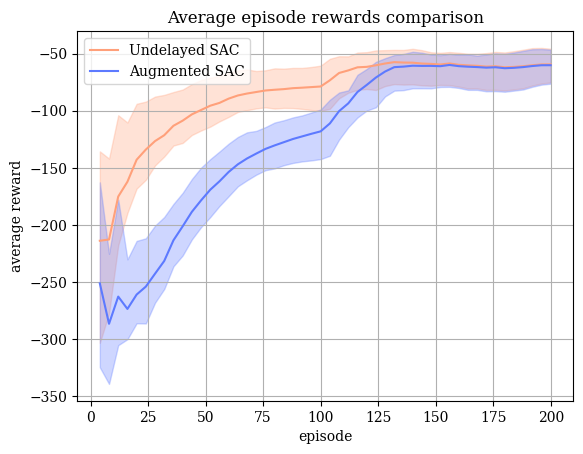

In [141]:
import pandas as pd

desired_states = [0.4, 0.8, 1.2]

delayed_rewards = []
aug_rewards = []


for desired in desired_states :
    delayeddf = pd.read_csv(f'logs\\train\\LinearVelocity\\0510\\Desired{desired}\\delayedsac\\progress.csv')
    augdf = pd.read_csv(f'logs\\train\\LinearVelocity\\0510\\Desired{desired}\\augsac\\progress.csv')

    delayed_rewards.append(delayeddf['rollout/ep_rew_mean'])
    aug_rewards.append(augdf['rollout/ep_rew_mean'])

delayed_rewards = np.array(delayed_rewards)
aug_rewards = np.array(aug_rewards)

avg_delayed_rewards = np.mean(delayed_rewards, axis = 0)
avg_aug_rewards = np.mean(aug_rewards, axis = 0)

dmin = np.min(delayed_rewards, axis = 0)
dmax = np.max(delayed_rewards, axis = 0)

amin = np.min(aug_rewards, axis = 0)
amax = np.max(aug_rewards, axis = 0)

f, ax = plt.subplots(1,1)
ax.plot(delayeddf['time/episodes'], avg_delayed_rewards, color = global_config.COLORS['cold_orange'])
ax.plot(augdf['time/episodes'], avg_aug_rewards, color = global_config.COLORS['warm_blue'])
ax.fill_between(delayeddf['time/episodes'], dmin, dmax, color = global_config.COLORS['cold_orange'],  alpha = .3)
ax.fill_between(augdf['time/episodes'], amin, amax, color = global_config.COLORS['warm_blue'], alpha = .3)
ax.set_title('Average episode rewards comparison')
ax.grid()
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.legend(['Undelayed SAC', 'Augmented SAC'])

## Nonlinear velocity

In [85]:
desired_states = [0.4, 0.8, 1.2]
seeds = [0, 42, 57]
n_episodes = 200
init_delay = 10

### Delayed

In [86]:
for run_idx in range(len(desired_states)): 
    delayednl_model, nlcore_env = train_default_delayed_sac(env_type = 'nonlinear', 
                                                              agent_type='delayedsac', 
                                                              init_delay = init_delay, 
                                                              desired_state=desired_states[run_idx], 
                                                              seed = seeds[run_idx], 
                                                              n_episodes = n_episodes)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/NonLinearVelocity/0509/Desired0.4/delayedsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -125     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 39       |
|    time_elapsed    | 12       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 1.46     |
|    critic_loss     | 0.00639  |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -89.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 37       |
|    time_elapsed    | 25       |
|    total_timesteps | 

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\NonLinearVelocity\Desired0.4' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -93.6    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 41       |
|    time_elapsed    | 11       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 1.12     |
|    critic_loss     | 0.0148   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -73.6    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 37       |
|    time_elapsed    | 25       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 1.27     |
|    critic_loss     | 0.0117   |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\NonLinearVelocity\Desired0.8' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -53.8    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 42       |
|    time_elapsed    | 11       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | -0.0188  |
|    critic_loss     | 0.00906  |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -39.6    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 39       |
|    time_elapsed    | 24       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | -0.43    |
|    critic_loss     | 0.00574  |
|    ent_coef        | 0.5      |
|    learning_

### Augmented

In [87]:
for run_idx in range(len(desired_states)): 
    augnlmodel, nlcore_env = train_default_augmented_sac(env_type = 'nonlinear', 
                                                        agent_type = 'augsac', 
                                                        init_delay = init_delay,
                                                        desired_state  = desired_states[run_idx], 
                                                        n_episodes = n_episodes, 
                                                        random_delay  = False,
                                                        seed  = seeds[run_idx])

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/NonLinearVelocity/0509/Desired0.4/augsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -110     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 31       |
|    time_elapsed    | 15       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 0.688    |
|    critic_loss     | 0.00427  |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -157     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 29       |
|    time_elapsed    | 32       |
|    total_timesteps | 960 

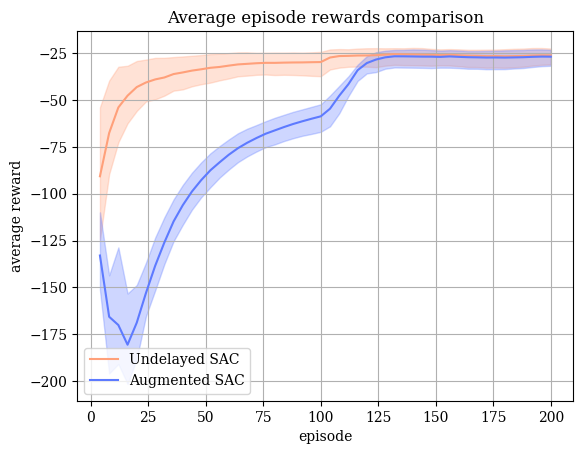

In [134]:
import pandas as pd

desired_states = [0.4, 0.8, 1.2]

delayed_rewards = []
aug_rewards = []


for desired in desired_states :
    delayeddf = pd.read_csv(f'logs\\train\\NonLinearVelocity\\0509\\Desired{desired}\\delayedsac\\progress.csv')
    augdf = pd.read_csv(f'logs\\train\\NonLinearVelocity\\0509\\Desired{desired}\\augsac\\progress.csv')

    delayed_rewards.append(delayeddf['rollout/ep_rew_mean'])
    aug_rewards.append(augdf['rollout/ep_rew_mean'])

delayed_rewards = np.array(delayed_rewards)
aug_rewards = np.array(aug_rewards)

avg_delayed_rewards = np.mean(delayed_rewards, axis = 0)
avg_aug_rewards = np.mean(aug_rewards, axis = 0)

dmin = np.min(delayed_rewards, axis = 0)
dmax = np.max(delayed_rewards, axis = 0)

amin = np.min(aug_rewards, axis = 0)
amax = np.max(aug_rewards, axis = 0)

f, ax = plt.subplots(1,1)
ax.plot(delayeddf['time/episodes'], avg_delayed_rewards, color = global_config.COLORS['cold_orange'])
ax.plot(augdf['time/episodes'], avg_aug_rewards, color = global_config.COLORS['warm_blue'])
ax.fill_between(delayeddf['time/episodes'], dmin, dmax, color = global_config.COLORS['cold_orange'],  alpha = .3)
ax.fill_between(augdf['time/episodes'], amin, amax, color = global_config.COLORS['warm_blue'], alpha = .3)
ax.set_title('Average episode rewards comparison')
ax.grid()
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.legend(['Undelayed SAC', 'Augmented SAC'])

## Position

In [88]:
desired_states = [[0.0, 0.4], [0.0, 0.8], [0.0, 1.2]]
seeds = [0, 42, 57]
n_episodes = 200
init_delay = 10

### Delayed

In [98]:
for run_idx in range(len(desired_states)): 
    delayedpos_model, poscore_env = train_default_delayed_sac(env_type = 'position', 
                                                              agent_type='delayedsac', 
                                                              init_delay = init_delay, 
                                                              desired_state=desired_states[run_idx], 
                                                              seed = seeds[run_idx], 
                                                              n_episodes = n_episodes)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/Position/0509/Desired[0.0, 0.4]/delayedsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -385     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 20       |
|    time_elapsed    | 23       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 6.5      |
|    critic_loss     | 0.0132   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -315     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 20       |
|    time_elapsed    | 46       |
|    total_timesteps | 96

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\Position\Desired[0.0, 0.4]' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -197     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 38       |
|    time_elapsed    | 12       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 3.44     |
|    critic_loss     | 0.00335  |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -226     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 34       |
|    time_elapsed    | 27       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 6.46     |
|    critic_loss     | 0.00373  |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\Position\Desired[0.0, 0.8]' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -164     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 40       |
|    time_elapsed    | 11       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 2.7      |
|    critic_loss     | 0.00713  |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -231     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 38       |
|    time_elapsed    | 25       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 5.92     |
|    critic_loss     | 0.0085   |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\Position\Desired[0.0, 1.2]' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


### Augmented

In [ ]:
for run_idx in range(len(desired_states)): 
    augposmodel, poscore_env = train_default_augmented_sac(env_type = 'position', 
                                                        agent_type = 'augsac', 
                                                        init_delay = init_delay,
                                                        desired_state  = desired_states[run_idx], 
                                                        n_episodes = n_episodes, 
                                                        random_delay  = False,
                                                        seed  = seeds[run_idx])

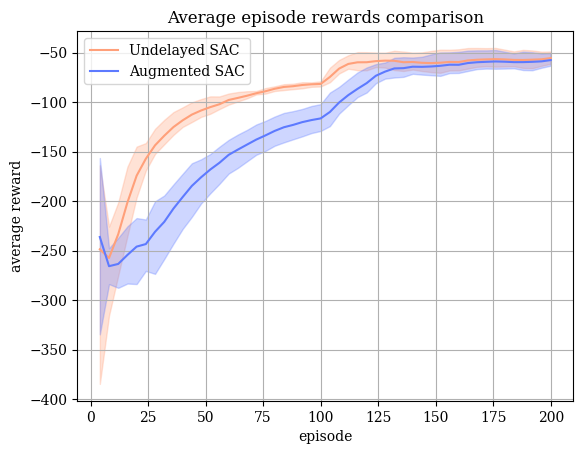

In [135]:
import pandas as pd

desired_states = [[0.0, 0.4], [0.0, 0.8], [0.0, 1.2]]

delayed_rewards = []
aug_rewards = []


for desired in desired_states :
    delayeddf = pd.read_csv(f'logs\\train\\Position\\0509\\Desired{desired}\\delayedsac\\progress.csv')
    augdf = pd.read_csv(f'logs\\train\\Position\\0510\\Desired{desired}\\augsac\\progress.csv')

    delayed_rewards.append(delayeddf['rollout/ep_rew_mean'])
    aug_rewards.append(augdf['rollout/ep_rew_mean'])

delayed_rewards = np.array(delayed_rewards)
aug_rewards = np.array(aug_rewards)

avg_delayed_rewards = np.mean(delayed_rewards, axis = 0)
avg_aug_rewards = np.mean(aug_rewards, axis = 0)

dmin = np.min(delayed_rewards, axis = 0)
dmax = np.max(delayed_rewards, axis = 0)

amin = np.min(aug_rewards, axis = 0)
amax = np.max(aug_rewards, axis = 0)

f, ax = plt.subplots(1,1)
ax.plot(delayeddf['time/episodes'], avg_delayed_rewards, color = global_config.COLORS['cold_orange'])
ax.plot(augdf['time/episodes'], avg_aug_rewards, color = global_config.COLORS['warm_blue'])
ax.fill_between(delayeddf['time/episodes'], dmin, dmax, color = global_config.COLORS['cold_orange'],  alpha = .3)
ax.fill_between(augdf['time/episodes'], amin, amax, color = global_config.COLORS['warm_blue'], alpha = .3)
ax.set_title('Average episode rewards comparison')
ax.grid()
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.legend(['Undelayed SAC', 'Augmented SAC'])

## RobotSteer

In [100]:
desired_states = [[0.0, 0.4, 1.7, 0.0], [0.0, 0.8, 0.8, 0.0], [0.0, 2.5, 1.0, 0.0]]
seeds = [0, 42, 57]
n_episodes = 200
init_delay = 10

### Delayed

In [111]:
# for run_idx in range(len(desired_states)): 
run_idx = -1
delayedrob_model, robcore_env = train_default_delayed_sac(env_type = 'robotsteer', 
                                                              agent_type='delayedsac', 
                                                              init_delay = init_delay, 
                                                              desired_state=desired_states[run_idx], 
                                                              seed = seeds[run_idx], 
                                                              n_episodes = n_episodes)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/RobotSteer/0510/Desired[0.0, 2.5, 1.0, 0.0]/delayedsac


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -475     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 23       |
|    time_elapsed    | 20       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 7.14     |
|    critic_loss     | 0.181    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -548     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 25       |
|    time_elapsed    | 38       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 0.16     |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\RobotSteer\Desired[0.0, 2.5, 1.0, 0.0]' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


### Augmented

In [112]:
for run_idx in range(len(desired_states)): 
    augrobmodel, robcore_env = train_default_augmented_sac(env_type = 'robotsteer', 
                                                        agent_type = 'augsac', 
                                                        init_delay = init_delay,
                                                        desired_state  = desired_states[run_idx], 
                                                        n_episodes = n_episodes, 
                                                        random_delay  = False,
                                                        seed  = seeds[run_idx])

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/RobotSteer/0510/Desired[0.0, 0.4, 1.7, 0.0]/augsac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -896     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 17       |
|    time_elapsed    | 27       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 0.449    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -733     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 19       |
|    time_elapsed    | 48       |
|    total_timest

### Plots

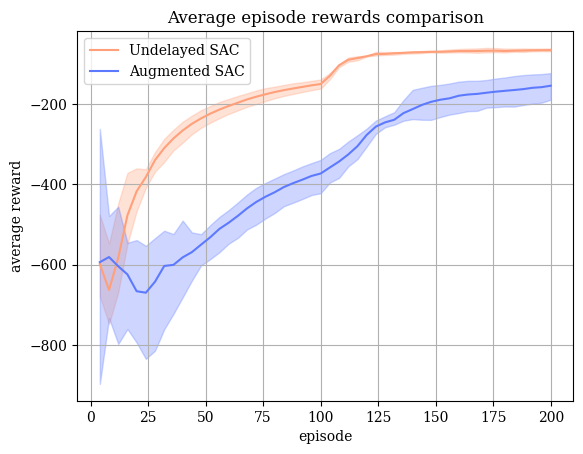

In [132]:
import pandas as pd

delayed_rewards = []
aug_rewards = []


for desired in desired_states :
    robdelayeddf = pd.read_csv(f'logs\\train\\RobotSteer\\0510\\Desired{desired}\\delayedsac\\progress.csv')
    robaugdf = pd.read_csv(f'logs\\train\\RobotSteer\\0510\\Desired{desired}\\augsac\\progress.csv')

    delayed_rewards.append(robdelayeddf['rollout/ep_rew_mean'])
    aug_rewards.append(robaugdf['rollout/ep_rew_mean'])

delayed_rewards = np.array(delayed_rewards)
aug_rewards = np.array(aug_rewards)

avg_delayed_rewards = np.mean(delayed_rewards, axis = 0)
avg_aug_rewards = np.mean(aug_rewards, axis = 0)

dmin = np.min(delayed_rewards, axis = 0)
dmax = np.max(delayed_rewards, axis = 0)

amin = np.min(aug_rewards, axis = 0)
amax = np.max(aug_rewards, axis = 0)

f, ax = plt.subplots(1,1)
ax.plot(robdelayeddf['time/episodes'], avg_delayed_rewards, color = global_config.COLORS['cold_orange'])
ax.plot(robaugdf['time/episodes'], avg_aug_rewards, color = global_config.COLORS['warm_blue'])
ax.fill_between(robdelayeddf['time/episodes'], dmin, dmax, color = global_config.COLORS['cold_orange'],  alpha = .3)
ax.fill_between(robaugdf['time/episodes'], amin, amax, color = global_config.COLORS['warm_blue'], alpha = .3)
ax.set_title('Average episode rewards comparison')
ax.grid()
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.legend(['Undelayed SAC', 'Augmented SAC'])

Delayed model delay : 10


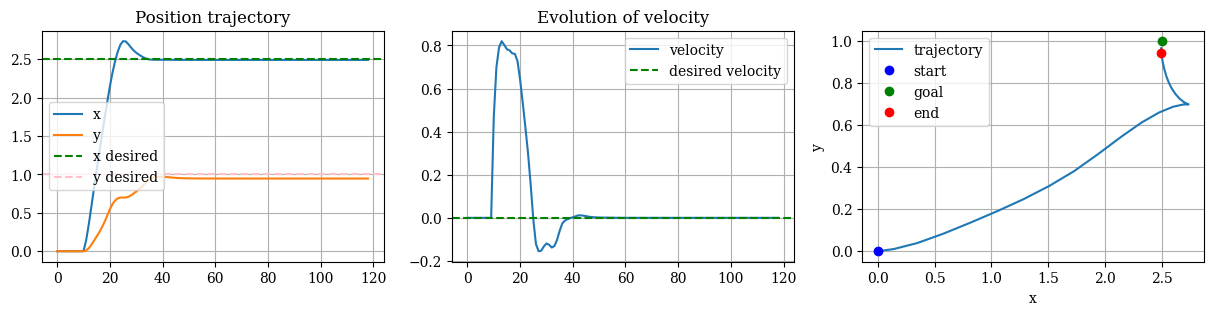

In [123]:
env = DelayAction(RescaleAction(robcore_env), delay = 10)
robcore_env.start_state = np.array([0.0,0.0,0.0,0.0])
print(f"Delayed model delay : {delayedrob_model.delay}")
delayedrob_model.original_env = env

states, actions, rewards, avg_rewards, executed_actions = test_augmented_agent(delayedrob_model, env, deterministic=True)
import pandas as pd

desired_states = [0.4, 0.8, 1.2]

delayed_rewards = []
aug_rewards = []


for desired in desired_states :
    delayeddf = pd.read_csv(f'logs\\train\\LinearVelocity\\0510\\Desired{desired}\\delayedsac\\progress.csv')
    augdf = pd.read_csv(f'logs\\train\\LinearVelocity\\0510\\Desired{desired}\\augsac\\progress.csv')

    delayed_rewards.append(delayeddf['rollout/ep_rew_mean'])
    aug_rewards.append(augdf['rollout/ep_rew_mean'])

delayed_rewards = np.array(delayed_rewards)
aug_rewards = np.array(aug_rewards)

avg_delayed_rewards = np.mean(delayed_rewards, axis = 0)
avg_aug_rewards = np.mean(aug_rewards, axis = 0)

dmin = np.min(delayed_rewards, axis = 0)
dmax = np.max(delayed_rewards, axis = 0)

amin = np.min(aug_rewards, axis = 0)
amax = np.max(aug_rewards, axis = 0)

f, ax = plt.subplots(1,1)
ax.plot(delayeddf['time/episodes'], avg_delayed_rewards, color = global_config.COLORS['cold_orange'])
ax.plot(augdf['time/episodes'], avg_aug_rewards, color = global_config.COLORS['warm_blue'])
ax.fill_between(delayeddf['time/episodes'], dmin, dmax, color = global_config.COLORS['cold_orange'],  alpha = .3)
ax.fill_between(augdf['time/episodes'], amin, amax, color = global_config.COLORS['warm_blue'], alpha = .3)
ax.set_title('Average episode rewards comparison')
ax.grid()
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.legend(['Undelayed SAC', 'Augmented SAC'])plot_test(env, states, rewards,actions, executed_actions, states_indexes = [1,2])

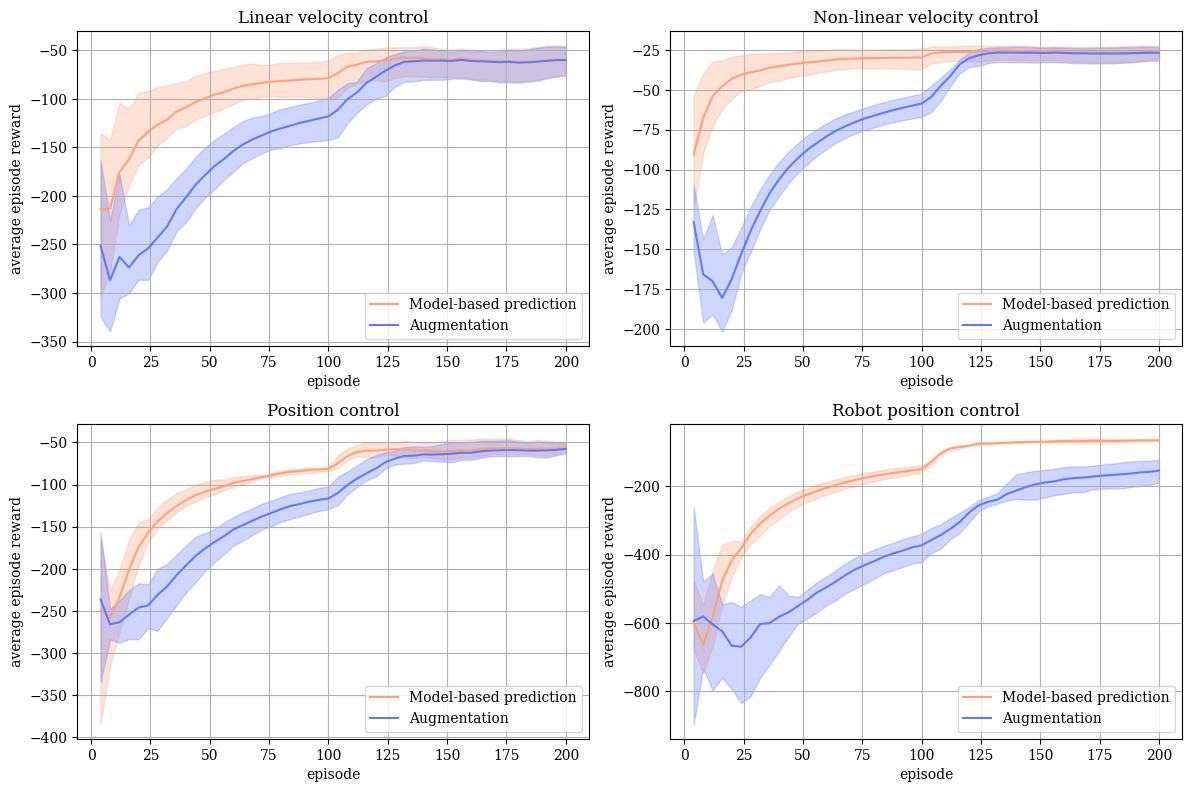

In [155]:

type_path_dict = {
    'linear' : 'logs\\train\\LinearVelocity\\0510',
    'linear_a' : 'logs\\train\\LinearVelocity\\0510',
    'nonlinear' : 'logs\\train\\NonLinearVelocity\\0509',
    'nonlinear_a' : 'logs\\train\\NonLinearVelocity\\0509',
    'position': 'logs\\train\\Position\\0509',
    'position_a': 'logs\\train\\Position\\0510', 
    'robotsteer': 'logs\\train\\RobotSteer\\0510',
    'robotsteer_a': 'logs\\train\\RobotSteer\\0510'

}

type_desired_dict = {
    'linear' : [0.4, 0.8, 1.2], 
    'nonlinear' : [0.4, 0.8, 1.2],
    'position': [[0.0, 0.4], [0.0, 0.8], [0.0, 1.2]],
    'robotsteer':  [[0.0, 0.4, 1.7, 0.0], [0.0, 0.8, 0.8, 0.0], [0.0, 2.5, 1.0, 0.0]]
}

type_title_dict = {
    'linear' : 'Linear velocity control',
    'nonlinear' : 'Non-linear velocity control',
    'position': 'Position control',
    'robotsteer': 'Robot position control'
}



f, ax = plt.subplots(2,2, figsize = (12, 8))
j = 0
i = 0
for idx, env_type in enumerate(['linear','nonlinear','position','robotsteer']): 
    
    delayed_rewards = []
    aug_rewards = []

    desired_states = type_desired_dict[env_type]
    logpath_d = type_path_dict[env_type]
    logpath_a =  type_path_dict[env_type+ '_a']


    for desired in desired_states :
        delayeddf = pd.read_csv(f'{logpath_d}\\Desired{desired}\\delayedsac\\progress.csv')
        augdf = pd.read_csv(f'{logpath_a}\\Desired{desired}\\augsac\\progress.csv')

        delayed_rewards.append(delayeddf['rollout/ep_rew_mean'])
        aug_rewards.append(augdf['rollout/ep_rew_mean'])

    delayed_rewards = np.array(delayed_rewards)
    aug_rewards = np.array(aug_rewards)

    avg_delayed_rewards = np.mean(delayed_rewards, axis = 0)
    avg_aug_rewards = np.mean(aug_rewards, axis = 0)

    dmin = np.min(delayed_rewards, axis = 0)
    dmax = np.max(delayed_rewards, axis = 0)

    amin = np.min(aug_rewards, axis = 0)
    amax = np.max(aug_rewards, axis = 0)

    if idx == 1 : 
        i = 0
        j = 1
    elif idx == 2: 
        i = 1
        j = 0
    elif idx == 3:
        i = 1
        j = 1

    ax[i, j].plot(delayeddf['time/episodes'], avg_delayed_rewards, color = global_config.COLORS['cold_orange'])
    ax[i, j].plot(augdf['time/episodes'], avg_aug_rewards, color = global_config.COLORS['warm_blue'])
    ax[i, j].fill_between(delayeddf['time/episodes'], dmin, dmax, color = global_config.COLORS['cold_orange'],  alpha = .3)
    ax[i, j].fill_between(augdf['time/episodes'], amin, amax, color = global_config.COLORS['warm_blue'], alpha = .3)
    ax[i, j].set_title(type_title_dict[env_type])
    ax[i, j].grid()
    ax[i, j].set_xlabel('episode')
    ax[i, j].set_ylabel('average episode reward')
    ax[i, j].legend(['Model-based prediction', 'Augmentation'], loc = 'lower right')

f.tight_layout(pad = 1)

    